In [36]:
library(dplyr)
library(survival)
library(survminer)
library(pROC)           
library(rms)          
library(glmnet)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Loading required package: Hmisc

Warning message:
“package ‘Hmisc’ was built under R version 4.4.3”

Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units


Loading required package: Matrix

Warning message:
“package ‘Matrix’ was built under R version 4.4.3”
Loaded glmnet 4.1-8



In [37]:
uromol_data    <- readRDS("/projects/rli_prj/Courses/BIOF520/UROMOL_TaLG.teachingcohort.rds")
knowles_data   <- readRDS("/projects/rli_prj/Courses/BIOF520/knowles_matched_TaLG_final.rds")

In [38]:
# First get the max value (ignoring NAs)
max_val <- max(uromol_data$RFS_time, na.rm = TRUE)

# Count how many times it appears (excluding NAs)
sum(uromol_data$RFS_time == max_val, na.rm = TRUE)


[1] 1

In [39]:
knowles_data$UROMOL2021.classification <- gsub("_", " ", knowles_data$UROMOL2021.classification)

In [40]:
summary(uromol_data)
summary(knowles_data)

  UROMOL.ID          Progression        PFS_time.        Recurrence    
 Length:286         Min.   :0.00000   Min.   :  1.83   Min.   :0.0000  
 Class :character   1st Qu.:0.00000   1st Qu.: 43.75   1st Qu.:0.0000  
 Mode  :character   Median :0.00000   Median : 61.43   Median :1.0000  
                    Mean   :0.06714   Mean   : 66.04   Mean   :0.6884  
                    3rd Qu.:0.00000   3rd Qu.: 82.48   3rd Qu.:1.0000  
                    Max.   :1.00000   Max.   :257.87   Max.   :1.0000  
                    NA's   :3         NA's   :3        NA's   :10      
    RFS_time        FUtime_days.       Age            Sex           
 Min.   :  0.070   Min.   :   0   Min.   :23.00   Length:286        
 1st Qu.:  6.482   1st Qu.:1246   1st Qu.:60.00   Class :character  
 Median : 17.580   Median :1748   Median :66.00   Mode  :character  
 Mean   : 27.265   Mean   :1921   Mean   :66.29                     
 3rd Qu.: 41.940   3rd Qu.:2426   3rd Qu.:74.00                     
 Max.   :1

  Progression   PFS_time.     Recurrence        RFS_time       FUtime_days. 
 Min.   :0    Min.   : NA   Min.   :0.0000   Min.   :  5.00   Min.   : 120  
 1st Qu.:0    1st Qu.: NA   1st Qu.:0.0000   1st Qu.: 10.75   1st Qu.:1170  
 Median :0    Median : NA   Median :0.0000   Median : 14.00   Median :1740  
 Mean   :0    Mean   :NaN   Mean   :0.3973   Mean   : 21.96   Mean   :1896  
 3rd Qu.:0    3rd Qu.: NA   3rd Qu.:1.0000   3rd Qu.: 27.25   3rd Qu.:2190  
 Max.   :0    Max.   : NA   Max.   :1.0000   Max.   :101.00   Max.   :4800  
 NA's   :4    NA's   :77    NA's   :4        NA's   :49       NA's   :4     
      Age            Sex            Tumor.stage        Tumor.grade       
 Min.   :24.00   Length:77          Length:77          Length:77         
 1st Qu.:59.00   Class :character   Class :character   Class :character  
 Median :70.00   Mode  :character   Mode  :character   Mode  :character  
 Mean   :66.61                                                           
 3rd Qu.:77.00

In [41]:
colnames(uromol_data)
colnames(knowles_data)

[1] "UROMOL.ID"                 "Progression"              
 [3] "PFS_time."                 "Recurrence"               
 [5] "RFS_time"                  "FUtime_days."             
 [7] "Age"                       "Sex"                      
 [9] "Smoking"                   "Tumor.stage"              
[11] "Tumor.grade"               "Concomitant.CIS"          
[13] "Tumor.size"                "Incident.tumor"           
[15] "EAU.risk"                  "BCG"                      
[17] "UROMOL2021.classification" "exprs"

[1] "Progression"               "PFS_time."                
 [3] "Recurrence"                "RFS_time"                 
 [5] "FUtime_days."              "Age"                      
 [7] "Sex"                       "Tumor.stage"              
 [9] "Tumor.grade"               "Concomitant.CIS"          
[11] "BCG"                       "UROMOL2021.classification"
[13] "exprs"                     "knowles_ID"

In [42]:
# knowles_data$FUtime_days.

In [43]:
# Calculate variance for each column
variances <- apply(uromol_data$exprs, 2, var)

# Identify columns with zero variance
constant_columns <- names(variances[variances == 0])
print(constant_columns)

[1] "LncRNA2747_ENSG00000256494"


In [44]:
# Keep only columns with non-zero variance
uromol_data$exprs <- uromol_data$exprs[, variances != 0]

In [45]:
pca_result <- prcomp(uromol_data$exprs, center = TRUE, scale. = TRUE)


In [46]:
# Extract the first several principal components
pc_two <- pca_result$x[, 1:2]
pc_customized <- pca_result$x[, 1:4]

# Replace the original expression data with these dimensions
uromol_data$exprs <- pc_customized


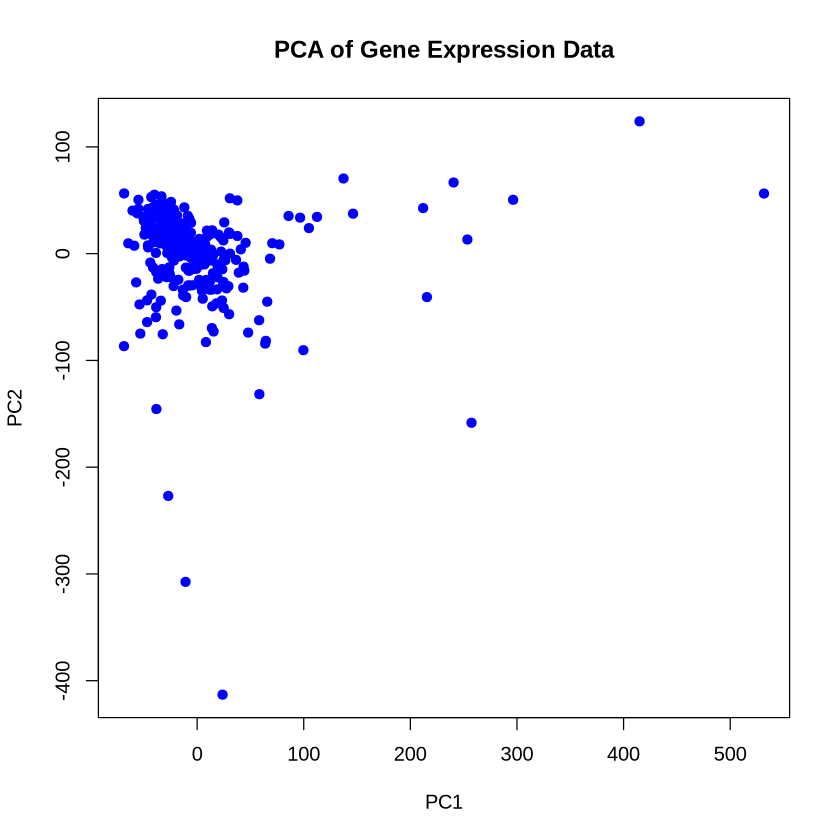

In [47]:
# Plot the first two principal components
plot(pca_result$x[,1], pca_result$x[,2],
     xlab = "PC1", ylab = "PC2",
     main = "PCA of Gene Expression Data",
     pch = 19, col = "blue")

In [48]:
# uromol_data$exprs
# uromol_data$Concomitant.CIS
# uromol_data$Incident.tumor
# uromol_data$EAU.risk
# knowles_data$BCG

In [49]:
uromol_data$Sex <- as.factor(uromol_data$Sex)
uromol_data$Smoking <- as.factor(uromol_data$Smoking)
uromol_data$Tumor.stage <- as.factor(uromol_data$Tumor.stage)
uromol_data$Tumor.grade <- as.factor(uromol_data$Tumor.grade)
uromol_data$Concomitant.CIS <- as.factor(uromol_data$Concomitant.CIS)
uromol_data$Incident.tumor <- as.factor(uromol_data$Incident.tumor)
uromol_data$EAU.risk <- as.factor(uromol_data$EAU.risk)
uromol_data$BCG <- as.factor(uromol_data$BCG)
# uromol_data$Progression <- as.factor(uromol_data$Progression)
uromol_data$UROMOL2021.classification <- as.factor(uromol_data$UROMOL2021.classification)
# uromol_data$exprs <- as.factor(uromol_data$exprs)

In [50]:
# Create a survival object using RFS_time (time) and Recurrence (event: 1=recurrence, 0=censored)
surv_obj <- Surv(time = uromol_data$RFS_time, event = uromol_data$Recurrence)

In [51]:
factor_vars <- sapply(uromol_data, is.factor)

# Check the number of unique levels for each factor variable
levels_count <- sapply(uromol_data[, factor_vars], function(x) length(unique(x)))
print(levels_count)


                      Sex                   Smoking               Tumor.stage 
                        2                         4                         1 
              Tumor.grade           Concomitant.CIS            Incident.tumor 
                        1                         2                         2 
                 EAU.risk                       BCG UROMOL2021.classification 
                        4                         2                         4 


In [52]:
# Remove Tumor.stage and Tumor.grade from the dataset
uromol_data <- uromol_data[, !(names(uromol_data) %in% c("Tumor.stage", "Tumor.grade"))]

# Rebuild the survival object if necessary (assuming RFS_time and Recurrence remain unchanged)
surv_obj <- Surv(time = uromol_data$RFS_time, event = uromol_data$Recurrence)

In [53]:
# 'Progression''PFS_time.''Recurrence''RFS_time''FUtime_days.''Age''Sex''Tumor.stage''Tumor.grade''Concomitant.CIS''BCG''UROMOL2021.classification''exprs''knowles_ID'
# uromol_data$Progression

In [54]:
# run the Cox proportional hazards model without the constant factors
cox_model <- coxph(Surv(RFS_time, Recurrence) ~ Age + Sex + Concomitant.CIS +
                BCG + UROMOL2021.classification + exprs + FUtime_days., 
                data = uromol_data, na.action = na.exclude)

cox_summary <- summary(cox_model)

In [55]:
# Extract the concordance index and its standard error
c_index <- cox_summary$concordance[1]
se_c_index <- cox_summary$concordance[2]

cat("C-index:", c_index, "\nStandard Error:", se_c_index, "\n")

C-index: 0.6369666 
Standard Error: 0.01958172 


In [56]:
# Check the proportional hazards assumption
ph_test <- cox.zph(cox_model)
print(ph_test)
# plot(ph_test)  # Plot Schoenfeld residuals

                            chisq df    p
Age                       0.76571  1 0.38
Sex                       0.09615  1 0.76
Concomitant.CIS           0.00396  1 0.95
BCG                       1.38113  1 0.24
UROMOL2021.classification 2.47190  3 0.48
exprs                     5.01634  4 0.29
FUtime_days.              0.11289  1 0.74
GLOBAL                    8.80938 12 0.72


In [57]:
# Calculate risk scores for each patient based on the model
uromol_data$risk_score <- predict(cox_model, type = "risk")

In [58]:
# uromol_data$risk_score

In [59]:
# Stratify patients into "High" and "Low" risk groups using the median risk score as a cutoff
uromol_data$risk_group <- ifelse(uromol_data$risk_score > median(uromol_data$risk_score, na.rm = TRUE), "High", "Low")

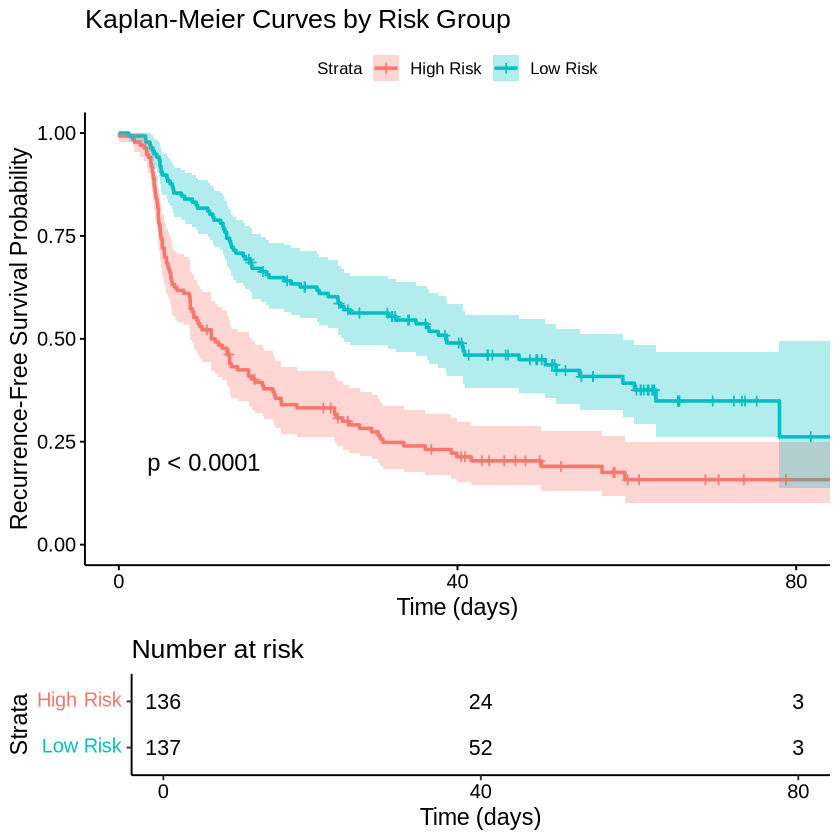

In [60]:
# Fit a Kaplan-Meier survival curve for the two risk groups
fit_km <- survfit(surv_obj ~ risk_group, data = uromol_data)

# Plot the Kaplan-Meier curves with risk table and p-value
ggsurvplot(fit_km, data = uromol_data,
        risk.table = TRUE,
        pval = TRUE,
        conf.int = TRUE,
        legend.labs = c("High Risk", "Low Risk"),
        title = "Kaplan-Meier Curves by Risk Group",
        xlab = "Time (days)",
        ylab = "Recurrence-Free Survival Probability",
        xlim = c(0, 80))

In [61]:
# Recode risk_group as binary: High = 1, Low = 0
uromol_data$risk_group_binary <- ifelse(uromol_data$risk_group == "High", 1, 0)

# Create a confusion matrix comparing predicted risk_group and actual Recurrence
confusion <- table(Predicted = uromol_data$risk_group_binary, Actual = uromol_data$Recurrence)
print(confusion)

# Calculate accuracy
accuracy <- sum(diag(confusion)) / sum(confusion)
print(paste("Accuracy:", round(accuracy, 3)))

# Calculate F1 score manually
# Extract true positives (TP), false positives (FP), and false negatives (FN)
# Make sure to check if the expected labels exist in the confusion matrix
TP <- ifelse("1" %in% rownames(confusion) & "1" %in% colnames(confusion), confusion["1", "1"], 0)
FP <- ifelse("1" %in% rownames(confusion) & "0" %in% colnames(confusion), confusion["1", "0"], 0)
FN <- ifelse("0" %in% rownames(confusion) & "1" %in% colnames(confusion), confusion["0", "1"], 0)

F1 <- ifelse((2 * TP + FP + FN) > 0, 2 * TP / (2 * TP + FP + FN), NA)
print(paste("F1 Score:", round(F1, 3)))

         Actual
Predicted   0   1
        0  59  78
        1  26 110
[1] "Accuracy: 0.619"
[1] "F1 Score: 0.679"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



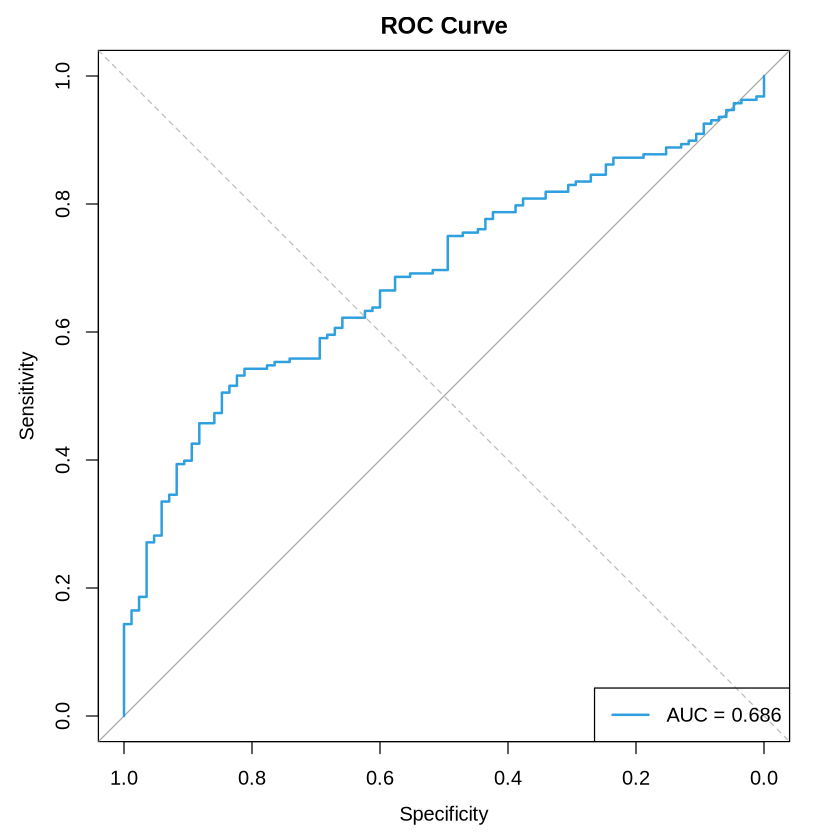

In [62]:
# Compute ROC and AUC
roc_obj <- roc(response = uromol_data$Recurrence,
               predictor = uromol_data$risk_score)

# Plot ROC curve
plot(roc_obj, col = "#2E9FDF", lwd = 2, main = "ROC Curve")
abline(a = 0, b = 1, lty = 2, col = "gray")  # diagonal reference line

# Add AUC text
auc_value <- auc(roc_obj)
legend("bottomright", legend = paste("AUC =", round(auc_value, 3)), 
       col = "#2E9FDF", lwd = 2)


In [63]:
uromol_data    <- readRDS("/projects/rli_prj/Courses/BIOF520/UROMOL_TaLG.teachingcohort.rds")
knowles_data   <- readRDS("/projects/rli_prj/Courses/BIOF520/knowles_matched_TaLG_final.rds")

In [64]:
knowles_data$UROMOL2021.classification <- gsub("_", " ", knowles_data$UROMOL2021.classification)

In [65]:
# Replace NA values in RFS_time with FUtime_days/30
knowles_data$RFS_time[is.na(knowles_data$RFS_time)] <- knowles_data$FUtime_days[is.na(knowles_data$RFS_time)]/30

In [66]:
knowles_data$RFS_time
knowles_data$FUtime_days

[1]   5  14  61 122  11  48  66  34  43  10  27  12  12  12  23  NA  NA  14  19
[20]  55  36  80  12  39  45 101  36  34 120  33  34  63  43  18  14  56  44  58
[39]   4  39  32 100  42 115   6  61  69  69  NA  23   5  66  65  40  40  42  14
[58]  73  52  28  16  21  31  69  10  39  NA  20  19   7  67   8  70  32  29  34
[77]   9

[1] 4110  840 1830 3660 2010 1440 1980 1020 1290 4350 1560  390 4290 3840  690
[16]   NA   NA  750 3630 1650 1080 2400 3870 1170 1350 3570 3000 2880 3600 4800
[31] 1020 1890 1290 1230 1800 1680 3750 1740  120 1170  960 3000 1260 3450 2550
[46] 1830 2070 2070   NA 1740 2010 1980 1950 1200 1200 1260 1830 2190 1560 1860
[61]  480 2910  930 2070  300 1170   NA  600  570 1620 2010  870 2100  960  870
[76] 1020 1200

In [67]:
required_vars <- c("RFS_time", "Recurrence", "Age", "Sex", "Concomitant.CIS", "BCG", 
                   "UROMOL2021.classification", "exprs", "FUtime_days.")

all(required_vars %in% colnames(knowles_data))  # should return TRUE


[1] TRUE

In [68]:
# Calculate variance for each column
variances <- apply(knowles_data$exprs, 2, var)

# Keep only columns with non-zero variance
knowles_data$exprs <- knowles_data$exprs[, variances != 0]
pca_result <- prcomp(knowles_data$exprs, center = TRUE, scale. = TRUE)
# Extract the first two principal components
pc_two <- pca_result$x[, 1:2]
pc_customized <- pca_result$x[, 1:4]

# Replace the original expression data with these two dimensions
knowles_data$exprs <- pc_customized

In [69]:
knowles_data <- knowles_data[complete.cases(knowles_data[, required_vars]), ]

In [70]:
# Make sure categorical variables are factors with levels matching the training data
knowles_data$Sex <- factor(trimws(knowles_data$Sex), levels = unique(trimws(uromol_data$Sex)))
knowles_data$Concomitant.CIS <- factor(trimws(knowles_data$Concomitant.CIS), levels = unique(trimws(uromol_data$Concomitant.CIS)))
# knowles_data$Incident.tumor <- factor(knowles_data$Incident.tumor, levels = levels(uromol_data$Incident.tumor))
knowles_data$BCG <- factor(trimws(knowles_data$BCG), levels = unique(trimws(uromol_data$BCG)))
knowles_data$UROMOL2021.classification <- factor(trimws(knowles_data$UROMOL2021.classification), levels = unique(trimws(uromol_data$UROMOL2021.classification)))

In [71]:
# Check factor levels
sapply(knowles_data[, sapply(knowles_data, is.factor)], levels)

$Sex
[1] "M" "F"

$Concomitant.CIS
[1] "No"  "Yes"

$BCG
[1] "0" "1"

$UROMOL2021.classification
[1] "Class 1"  "Class 2b" "Class 2a" "Class 3"

In [72]:
knowles_data$risk_score <- predict(cox_model, newdata = knowles_data, type = "risk")

In [73]:
# Stratify patients into High and Low risk groups
median_cutoff <- median(knowles_data$risk_score, na.rm = TRUE)
knowles_data$risk_group <- ifelse(knowles_data$risk_score > median_cutoff, "High", "Low")

In [74]:
# Rebuild the survival object if necessary (assuming RFS_time and Recurrence remain unchanged)
surv_obj <- Surv(time = knowles_data$RFS_time, event = knowles_data$Recurrence)

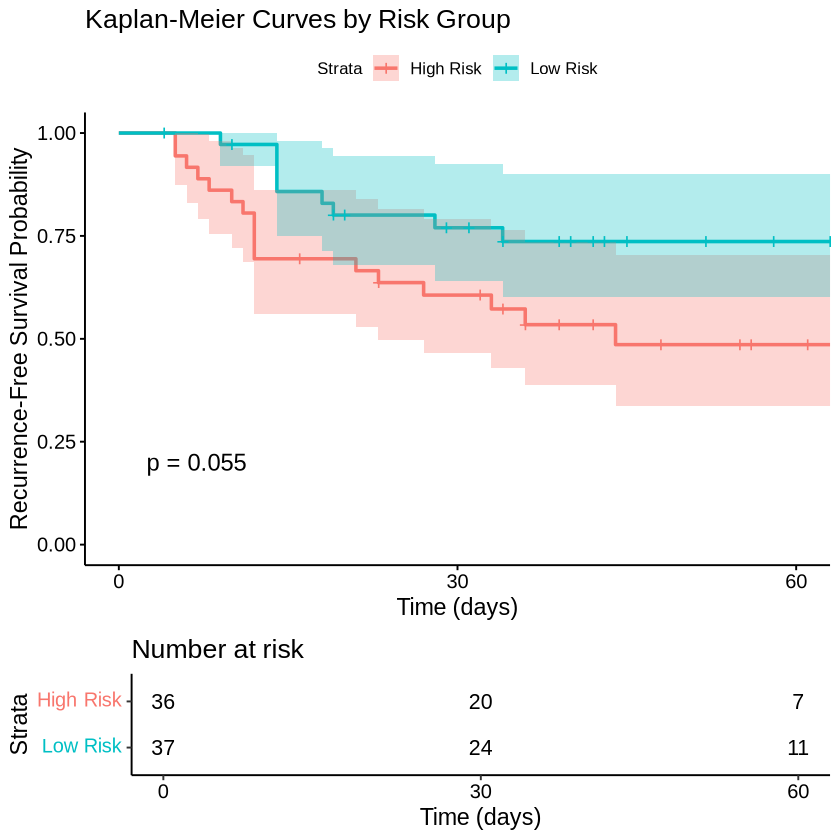

In [75]:
# Fit a Kaplan-Meier survival curve for the two risk groups
fit_km <- survfit(surv_obj ~ risk_group, data = knowles_data)

# Plot the Kaplan-Meier curves with risk table and p-value
ggsurvplot(fit_km, data = knowles_data,
        risk.table = TRUE,
        pval = TRUE,
        conf.int = TRUE,
        legend.labs = c("High Risk", "Low Risk"),
        title = "Kaplan-Meier Curves by Risk Group",
        xlab = "Time (days)",
        ylab = "Recurrence-Free Survival Probability",
        xlim = c(0, 60))

Setting levels: control = 0, case = 1

Setting direction: controls < cases



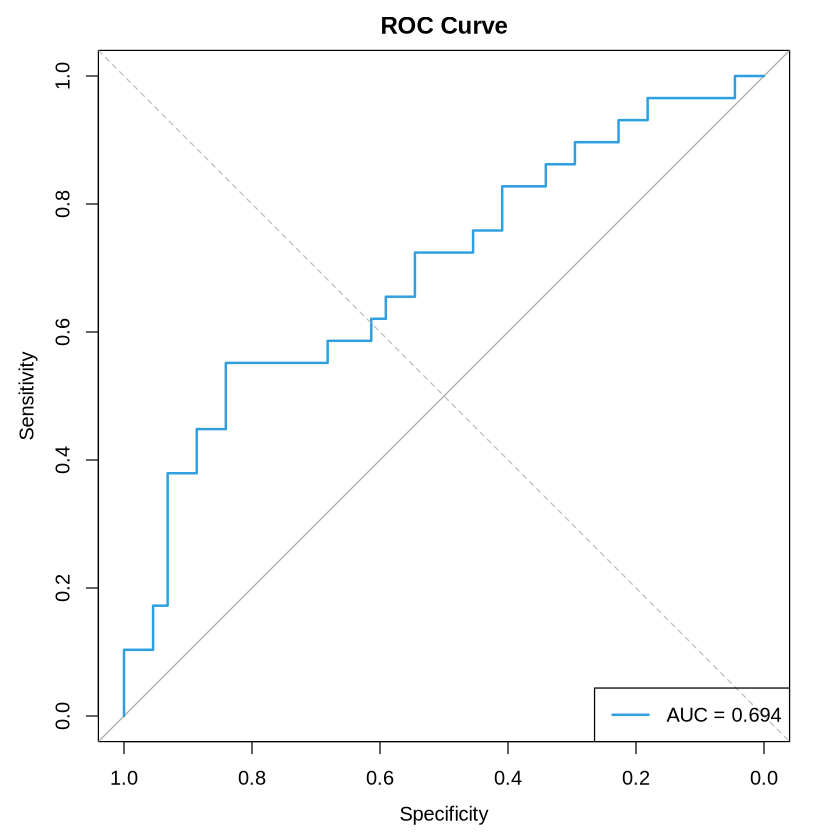

In [76]:
# Compute ROC and AUC
roc_obj <- roc(response = knowles_data$Recurrence,
               predictor = knowles_data$risk_score)

# Plot ROC curve
plot(roc_obj, col = "#2E9FDF", lwd = 2, main = "ROC Curve")
abline(a = 0, b = 1, lty = 2, col = "gray")  # diagonal reference line

# Add AUC text
auc_value <- auc(roc_obj)
legend("bottomright", legend = paste("AUC =", round(auc_value, 3)), 
       col = "#2E9FDF", lwd = 2)


In [77]:
old_warn <- options(warn = -1)

# Compute the concordance index using the risk scores and survival data
concordance_obj <- survConcordance(Surv(RFS_time, Recurrence) ~ risk_score, data = knowles_data)

# Extract the C-index and its standard error
c_index <- concordance_obj$concordance
se_c_index <- concordance_obj$std.err

cat("C-index:", c_index, "\nStandard Error:", se_c_index, "\n")


C-index: 0.6763485 
Standard Error: 0.05914312 
